In [1]:
# Bibliotecas básicas
import time, sys
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
import seaborn as sns

# Visualização
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tabulate import tabulate

# Análise estatística
from scipy.stats import norm, kstest
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning - Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Configurações de exibição
pd.options.display.float_format = '{:.4f}'.format  # Define o formato de exibição dos números float no pandas para quatro casas decimais
pd.set_option('display.expand_frame_repr', False)  # Não quebra a representação do dataframe
np.set_printoptions(precision=8, suppress=True, floatmode='maxprec') # Define o formato de exibição dos números float no numpy para oito casas decimais e sem notação científica


In [2]:

def teste_n(df, column_name, alpha=0.05):
    """
    Executa o teste de Kolmogorov-Smirnov para verificar se uma coluna do DataFrame segue uma distribuição normal.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados.
    column_name : str
        Nome da coluna a ser testada quanto à normalidade.
    alpha : float, opcional
        Nível de significância para o teste. O padrão é 0.05 (5%).

    Descrição:
    ----------
    - Normaliza os dados da coluna (subtrai a média e divide pelo desvio padrão).
    - Aplica o teste de Kolmogorov-Smirnov comparando com uma distribuição normal padrão.
    - Interpreta os resultados com base no p-valor e o nível de significância especificado.
    - Exibe uma mensagem informando se a distribuição pode ser considerada normal ou não.

    Retorno:
    --------
    tuple
        Uma tupla contendo (estatística do teste, p-valor).

    Exemplo de uso:
    --------------
    stat, p_valor = teste_n(df, 'pv_nafta')
    stat, p_valor = teste_n(df, 'pv_nafta', alpha=0.01)  # Usando significância de 1%
    """
    # Executar o teste de Kolmogorov-Smirnov - nesse caso em relação a uma distribuição normal
    stat, p_valor = kstest((df[column_name] - np.mean(df[column_name])) / np.std(df[column_name], ddof=1), 'norm')

    # Interpretar os resultados
    if p_valor > alpha:
        print("A amostra parece vir de uma distribuição normal (não podemos rejeitar a hipótese nula) p-valor:", f"{p_valor:.5f}")
    else:
        print("A amostra não parece vir de uma distribuição normal (rejeitamos a hipótese nula) p-valor:", f"{p_valor:.5f}")
    return float(stat), float(p_valor)

def calcula_corr(df):
    """
    Calcula e visualiza a matriz de correlação absoluta entre as variáveis de um DataFrame.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados para cálculo da correlação.

    Descrição:
    ----------
    - Remove valores NaN do DataFrame antes de calcular as correlações.
    - Calcula a matriz de correlação absoluta entre todas as variáveis.
    - Cria uma visualização interativa usando Plotly Express.
    - Aplica uma escala de cores Viridis para representar a intensidade das correlações.
    - Mostra os valores numéricos das correlações com duas casas decimais.

    Exemplo de uso:
    --------------
    calcula_corr(df)
    calcula_corr(df[selected_columns])  # Para um subconjunto de colunas
    """
    df_corr = df.dropna().corr().abs()

    fig = px.imshow(
        img    = df_corr,
        color_continuous_scale='Viridis',
        width  = 900, # caso não esteja visualizando todas as variáveis, altere esse valor
        height = 900, # caso não esteja visualizando todas as variáveis, altere esse valor
        text_auto = ".2f"  # Mostra os valores com 2 casas decimais
    )

    fig.update_traces(textfont_size=12)  # Altere o valor conforme desejado
    fig.show()

def pairplot_corr_hm(df, figsize=(12, 12), hist_bins=30, s=10, alpha=0.6):
    """
    Cria um pairplot onde a cor dos pontos é baseada na correlação absoluta entre variáveis
    usando uma paleta de cores Viridis.

    Parâmetros:
    -----------
    df : pandas DataFrame
        O DataFrame contendo os dados a serem plotados
    figsize : tuple, opcional
        Tamanho da figura (largura, altura) em polegadas
    hist_bins : int, opcional
        Número de bins para os histogramas na diagonal
    s : int, opcional
        Tamanho dos pontos nos gráficos de dispersão
    alpha : float, opcional
        Nível de transparência dos pontos (0-1)
    """

    # Obter a matriz de correlação absoluta
    corr_matrix = df.corr().abs()

    # Configurar a normalização de cores para a escala viridis
    norm = Normalize(vmin=0, vmax=1)

    # Obter as variáveis e o número de variáveis
    variables = df.columns
    n_vars = len(variables)

    # Criar a figura e os subplots
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)

    # Ajustar o espaçamento entre os subplots
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # Criar os gráficos para cada par de variáveis
    for i, var1 in enumerate(variables):
        for j, var2 in enumerate(variables):
            ax = axes[i, j]

            # Remover os ticks dos eixos internos
            if i < n_vars - 1:
                ax.set_xticks([])
            if j > 0:
                ax.set_yticks([])

            # Se estamos na diagonal, plotar histograma
            if i == j:
                ax.hist(df[var1], bins=hist_bins, alpha=0.7, color='darkblue')
                ax.set_title(var1, fontsize=10)
            else:
                # Obter a correlação absoluta entre as variáveis
                corr_val = corr_matrix.loc[var1, var2]

                # Determinar a cor com base na correlação
                color = viridis(norm(corr_val))

                # Criar o gráfico de dispersão
                ax.scatter(df[var2], df[var1], s=s, alpha=alpha, color=color)

                # Adicionar a correlação como texto no gráfico
                ax.text(0.05, 0.95, f'|ρ|: {corr_val:.2f}',
                        transform=ax.transAxes, fontsize=8,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Adicionar os nomes das variáveis apenas nos eixos externos
    for i, var in enumerate(variables):
        axes[n_vars-1, i].set_xlabel(var, fontsize=10)
        axes[i, 0].set_ylabel(var, fontsize=10)

    # Adicionar uma barra de cores para referência
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="viridis"), cax=cbar_ax)
    cb.set_label('Correlação Absoluta |ρ|')

    plt.suptitle('Pairplot com Cores Baseadas na Correlação Absoluta', fontsize=16)
    plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)

def calcula_vif(df,target):
    """
    Calcula o Fator de Inflação da Variância (VIF) para identificar multicolinearidade em variáveis.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo apenas as variáveis independentes para as quais se deseja calcular o VIF.

    Descrição:
    ----------
    - Adiciona uma constante ao DataFrame para o cálculo correto do VIF.
    - Calcula o VIF para cada variável usando a função variance_inflation_factor.
    - Ordena os resultados em ordem decrescente para identificar as variáveis mais problemáticas.
    - Exibe os resultados das 15 variáveis com maior VIF.

    # Retorno:
    # --------
    # pandas.DataFrame
    #     DataFrame contendo as variáveis e seus respectivos valores VIF.

    Interpretação:
    --------------
    - VIF = 1: Ausência de multicolinearidade
    - 1 < VIF < 5: Multicolinearidade moderada
    - 5 < VIF < 10: Multicolinearidade alta
    - VIF > 10: Multicolinearidade muito alta (problemática)

    Exemplo de uso:
    --------------
    vif_df = calcula_vif(df,target)  
    """
    # Remove a coluna da variável target, se existir
    X = df.drop(columns=[target]) if target in df.columns else df.copy()
    X_with_const = sm.add_constant(X)  # Adicionando uma constante
    vif = pd.DataFrame()
    vif["Variable"] = X_with_const.columns
    vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    vif.set_index('Variable', inplace=True)
    # Imprimir VIF em ordem decrescente
    print("\nVIF das variáveis (ordem decrescente):\n")
    print(vif.query("Variable != 'const'").sort_values(by='VIF', ascending=False).head(15).T)

    # return vif

def plot_boxplot_pdf(df, lower_lim=None, upper_lim=None, n_cols=4):
    """
    Plota boxplot horizontal e PDF (histograma + curva normal) para todas as colunas numéricas do DataFrame.
    O layout é de múltiplas linhas e n_cols colunas de subplots: para cada coluna, boxplot em cima, PDF embaixo.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados.
    lower_lim : float, str ou None, opcional
        Limite inferior do eixo x. Se None ou 'auto', usa o mínimo dos dados.
    upper_lim : float, str ou None, opcional
        Limite superior do eixo x. Se None ou 'auto', usa o máximo dos dados.
    n_cols : int, opcional
        Número de colunas no layout dos subplots. O padrão é 4.

    Descrição:
    ----------
    - Para cada variável numérica, cria dois gráficos alinhados verticalmente:
      - Um boxplot horizontal no topo para visualizar a distribuição e outliers
      - Um histograma com curva normal teórica abaixo para visualizar a distribuição de frequência
    - Adiciona linhas de referência nos gráficos (média, mediana, ±3σ)
    - Permite ajustar os limites dos eixos manualmente ou automaticamente
    - Remove automaticamente valores NaN antes de plotar

    Exemplo de uso:
    --------------
    plot_boxplot_pdf(df)
    plot_boxplot_pdf(df, upper_lim=100, lower_lim=0)  # Define limites fixos para todas as variáveis
    plot_boxplot_pdf(df, n_cols=3)  # Altera o número de colunas no layout
    """

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_vars = len(numeric_cols)
    n_rows = int(np.ceil(n_vars / n_cols))

    # Dobrar a altura dos plots da PDF (segunda linha de cada variável)
    height_ratios = []
    for _ in range(n_rows):
        height_ratios.extend([1, 4])  # boxplot:1, pdf:4

    fig, axes = plt.subplots(
        n_rows * 2,
        n_cols,
        figsize=(6 * n_cols, 5 * n_rows),
        gridspec_kw={'height_ratios': height_ratios}
    )

    axes = np.array(axes).reshape(n_rows * 2, n_cols)

    for idx, column in enumerate(numeric_cols):
        row = (idx // n_cols) * 2
        col = idx % n_cols
        data = df[column].dropna()

        # Use os valores reais dos dados para garantir que todos os outliers estejam visíveis
        data_min = data.min()
        data_max = data.max()

        # Se upper_lim/lower_lim forem fornecidos, use-os, senão use os valores reais dos dados
        if upper_lim is None or (isinstance(upper_lim, str) and upper_lim.lower() == 'auto'):
            x_upper = data_max
        else:
            try:
                x_upper = float(upper_lim)
            except (ValueError, TypeError):
                x_upper = data_max

        if lower_lim is None or (isinstance(lower_lim, str) and lower_lim.lower() == 'auto'):
            x_lower = data_min
        else:
            try:
                x_lower = float(lower_lim)
            except (ValueError, TypeError):
                x_lower = data_min

        # Para garantir que todos os pontos (inclusive outliers) sejam mostrados, defina os limites do eixo x
        # um pouco além dos valores mínimos e máximos reais dos dados
        margin = 0.02 * (data_max - data_min) if data_max > data_min else 1
        xlim_lower = data_min - margin
        xlim_upper = data_max + margin

        # Boxplot
        ax_box = axes[row, col]
        ax_box.boxplot(data, vert=False, patch_artist=True, widths=0.5, showfliers=True)
        ax_box.set_xlim(xlim_lower, xlim_upper)
        ax_box.set_yticks([])
        ax_box.set_xticklabels([])
        ax_box.set_title(f'Boxplot de {column}')

        # PDF (histograma + curva normal)
        ax_pdf = axes[row + 1, col]
        ax_pdf.hist(data, bins=30, color='lightblue', edgecolor='black', alpha=0.7, density=True, range=(xlim_lower, xlim_upper))

        if len(data) > 1:
            media = data.mean()
            std = data.std()
            x_grid = np.linspace(xlim_lower, xlim_upper, 200)
            y_norm = norm.pdf(x_grid, media, std)
            ax_pdf.plot(x_grid, y_norm, color='darkblue', lw=2, label='Normal')

            mediana = data.median()
            # Linhas estatísticas
            ax_box.axvline(media, color='blue', linestyle='-', label=f'Média: {media:.1f}')
            ax_box.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
            ax_box.axvline(media + 3*std, color='orange', linestyle=':', label=f'+3σ: {(media + 3*std):.1f}')
            ax_box.axvline(media - 3*std, color='orange', linestyle=':', label=f'-3σ: {(media - 3*std):.1f}')

            ax_pdf.axvline(media, color='blue', linestyle='-', label=f'Média: {media:.1f}')
            ax_pdf.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
            ax_pdf.axvline(media + 3*std, color='orange', linestyle=':', label=f'+3σ: {(media + 3*std):.1f}')
            ax_pdf.axvline(media - 3*std, color='orange', linestyle=':', label=f'-3σ: {(media - 3*std):.1f}')

        ax_pdf.set_xlim(xlim_lower, xlim_upper)
        ax_pdf.set_xlabel(column)
        ax_pdf.set_ylabel('Densidade')
        ax_pdf.set_title(f'PDF de {column}')
        ax_pdf.legend(fontsize=8, loc='upper left')

    # Remove subplots vazios
    total_plots = n_rows * n_cols
    for idx in range(n_vars, total_plots):
        for r in [0, 1]:
            fig.delaxes(axes[(idx // n_cols) * 2 + r, idx % n_cols])

    plt.tight_layout(h_pad=2.5)
    plt.show()

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# DataFrame unificado para armazenar todas as métricas dos modelos
# Será usado para baseline, otimização de hiperparâmetros e comparação final

# Estrutura do DataFrame unificado
results_columns = [
    'model_name',           # Nome do algoritmo (LinearRegression, Ridge, etc.)
    'scaler',               # Tipo de scaler (sem_normalizacao, minmax, standard)
    'hyperparams',          # Hiperparâmetros usados (para baseline será 'default')
    'optimization_method',  # Método de otimização (baseline, grid_search, random_search, etc.)
    'r2_train_mean',        # R² médio no treino
    'r2_train_std',         # Desvio padrão do R² no treino
    'r2_cv_mean',           # R² médio na validação cruzada
    'r2_cv_std',            # Desvio padrão do R² na validação cruzada
    'mse_train_mean',       # MSE médio no treino
    'mse_train_std',        # Desvio padrão do MSE no treino
    'mse_cv_mean',          # MSE médio na validação cruzada
    'mse_cv_std',           # Desvio padrão do MSE na validação cruzada
    'rmse_train_mean',      # RMSE médio no treino
    'rmse_train_std',       # Desvio padrão do RMSE no treino
    'rmse_cv_mean',         # RMSE médio na validação cruzada
    'rmse_cv_std',          # Desvio padrão do RMSE na validação cruzada
    'mae_train_mean',       # MAE médio no treino
    'mae_train_std',        # Desvio padrão do MAE no treino
    'mae_cv_mean',          # MAE médio na validação cruzada
    'mae_cv_std',           # Desvio padrão do MAE na validação cruzada
    'fit_time_mean',        # Tempo médio de treinamento
    'fit_time_std',         # Desvio padrão do tempo de treinamento
    'score_time_mean',      # Tempo médio de predição
    'score_time_std',       # Desvio padrão do tempo de predição
    'experiment_date'       # Data/hora do experimento
]

# Inicializar DataFrame unificado
all_results_df = pd.DataFrame(columns=results_columns)

# Função para adicionar resultados ao DataFrame unificado
def add_results_to_df(df, model_name, scaler_name, cv_results, hyperparams='default', optimization_method='baseline'):
    """
    Adiciona resultados de validação cruzada ao DataFrame unificado.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame unificado onde os resultados serão adicionados
    model_name : str
        Nome do modelo (ex: 'LinearRegression', 'Ridge')
    scaler_name : str
        Nome do scaler (ex: 'sem_normalizacao', 'minmax', 'standard')
    cv_results : dict
        Resultados da validação cruzada do sklearn
    hyperparams : str ou dict
        Hiperparâmetros utilizados
    optimization_method : str
        Método de otimização utilizado
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame atualizado com os novos resultados
    """
    from datetime import datetime
    
    # Converter hiperparâmetros para string se for dict
    if isinstance(hyperparams, dict):
        hyperparams_str = str(hyperparams)
    else:
        hyperparams_str = hyperparams
    
    # Criar novo registro
    new_row = {
        'model_name': model_name,
        'scaler': scaler_name,
        'hyperparams': hyperparams_str,
        'optimization_method': optimization_method,
        'r2_train_mean': cv_results['train_r2'].mean(),
        'r2_train_std': cv_results['train_r2'].std(),
        'r2_cv_mean': cv_results['test_r2'].mean(),
        'r2_cv_std': cv_results['test_r2'].std(),
        'mse_train_mean': -cv_results['train_mse'].mean(),
        'mse_train_std': cv_results['train_mse'].std(),
        'mse_cv_mean': -cv_results['test_mse'].mean(),
        'mse_cv_std': cv_results['test_mse'].std(),
        'rmse_train_mean': -cv_results['train_rmse'].mean(),
        'rmse_train_std': cv_results['train_rmse'].std(),
        'rmse_cv_mean': -cv_results['test_rmse'].mean(),
        'rmse_cv_std': cv_results['test_rmse'].std(),
        'mae_train_mean': -cv_results['train_mae'].mean(),
        'mae_train_std': cv_results['train_mae'].std(),
        'mae_cv_mean': -cv_results['test_mae'].mean(),
        'mae_cv_std': cv_results['test_mae'].std(),
        'fit_time_mean': cv_results['fit_time'].mean(),
        'fit_time_std': cv_results['fit_time'].std(),
        'score_time_mean': cv_results['score_time'].mean(),
        'score_time_std': cv_results['score_time'].std(),
        'experiment_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # Adicionar ao DataFrame usando pd.concat (mais eficiente que append)
    new_row_df = pd.DataFrame([new_row])
    updated_df = pd.concat([df, new_row_df], ignore_index=True)
    
    return updated_df

# Função para exibir resumo do DataFrame
def display_results_summary(df, top_n=10, metric='r2_cv_mean'):
    """
    Exibe resumo dos resultados ordenados por uma métrica específica.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame com os resultados
    top_n : int
        Número de melhores modelos a exibir
    metric : str
        Métrica para ordenação (padrão: 'r2_cv_mean')
    """
    if df.empty:
        print("DataFrame de resultados está vazio.")
        return
    
    # Ordenar por métrica (descendente para R², ascendente para erros)
    ascending = metric.startswith(('mse', 'rmse', 'mae', 'fit_time', 'score_time'))
    sorted_df = df.sort_values(by=metric, ascending=ascending)
    
    print(f"\n{'='*100}")
    print(f"TOP {top_n} MODELOS - Ordenados por {metric.upper()}")
    print(f"{'='*100}")
    
    # Colunas principais para exibir
    display_cols = ['model_name', 'scaler', 'optimization_method', 
                   'r2_cv_mean', 'mse_cv_mean', 'rmse_cv_mean', 'mae_cv_mean']
    
    # Verificar quais colunas existem
    available_cols = [col for col in display_cols if col in df.columns]
    
    print(sorted_df[available_cols].head(top_n).round(4).to_string(index=False))
    
    # Estatísticas gerais
    print(f"\n{'='*50}")
    print("ESTATÍSTICAS GERAIS:")
    print(f"{'='*50}")
    print(f"Total de experimentos: {len(df)}")
    print(f"Modelos únicos testados: {df['model_name'].nunique()}")
    print(f"Scalers testados: {df['scaler'].nunique()}")
    print(f"Métodos de otimização: {df['optimization_method'].nunique()}")
    
    if not df.empty:
        best_result = sorted_df.iloc[0]
        print(f"\nMelhor resultado:")
        print(f"- Modelo: {best_result['model_name']}")
        print(f"- Scaler: {best_result['scaler']}")
        print(f"- Método: {best_result['optimization_method']}")
        print(f"- {metric}: {best_result[metric]:.4f}")

print("DataFrame unificado criado com sucesso!")
print(f"Colunas disponíveis: {len(results_columns)}")
print("Funções auxiliares criadas:")
print("- add_results_to_df(): Adiciona resultados ao DataFrame")
print("- display_results_summary(): Exibe resumo dos resultados")

def print_metrics_table(model_name, scaler_name, cv_results):
    # Preparar os dados da tabela
    headers = ["Métrica", "Treino (média ± desvio)", "CV (média ± desvio)"]
    
    table_data = [
        ["R²", f"{cv_results['train_r2'].mean():.4f} (±{cv_results['train_r2'].std():.4f})", 
               f"{cv_results['test_r2'].mean():.4f} (±{cv_results['test_r2'].std():.4f})"],
        ["RMSE", f"{-cv_results['train_rmse'].mean():.4f} (±{cv_results['train_rmse'].std():.4f})", 
                f"{-cv_results['test_rmse'].mean():.4f} (±{cv_results['test_rmse'].std():.4f})"]
    ]
    
    # Imprimir a tabela
    print(f"\nModelo: {model_name.upper()} com Scaler: {scaler_name}")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

DataFrame unificado criado com sucesso!
Colunas disponíveis: 25
Funções auxiliares criadas:
- add_results_to_df(): Adiciona resultados ao DataFrame
- display_results_summary(): Exibe resumo dos resultados


In [3]:
url = "https://github.com/fdamata_petro/pucrj-analisededados-mvp-ml/raw/refs/heads/main/dataset_pv_nafta_ml.xlsx"
url = 'dataset_pv_nafta_ml.xlsx'


df = pd.read_excel(url) # Carregamento do dataset
df.head() # Imprime as primeiras linhas do dataset

,pv_nafta,t_fund_nafta,t_topo_nafta,t_lhtp_nafta,p_topo_nafta,t_aque_nafta,t_carg_nafta,t_einf_nafta,t_eint_nafta,t_esup_nafta,f_carg_nafta,f_refl_nafta
0,86.4425,277.2240,201.7273,178.8781,135.4578,286.4749,240.6413,248.3394,209.0250,203.7005,47.6830,9.3789
1,91.0837,277.6905,199.9552,176.9958,135.1978,286.7427,241.9322,245.2918,207.9087,201.4806,40.0747,5.6912
2,92.8241,277.5102,199.3828,177.5044,135.4634,286.9606,241.3938,245.1197,207.3670,201.7646,41.2830,4.9506
3,91.6638,277.8457,199.9700,177.0162,135.3820,287.6555,242.1277,245.1870,207.8621,201.7675,41.4406,5.3604
4,92.8241,275.1131,199.3226,176.9452,135.1458,284.8345,239.7532,243.2034,207.3791,201.4840,41.3072,4.9588


In [4]:
print(f"Total de instâncias: {len(df)}")

tags = df.columns.to_list()

# Definição de que a variável dependente está na primeira coluna
target = tags[0]
inputs = [tag for tag in tags if tag != target]

print(f'Num. de atributos: {len(tags)}')
# Separação entre variável dependente (target) e independentes (inputs)
print(f'target = {target}')
print(f'inputs = {inputs}')
# print(f'Num. inputs = {len(inputs)}')

print("\nTipos de dados por coluna:\n")

print(df.info())

Total de instâncias: 945
Num. de atributos: 12
target = pv_nafta
inputs = ['t_fund_nafta', 't_topo_nafta', 't_lhtp_nafta', 'p_topo_nafta', 't_aque_nafta', 't_carg_nafta', 't_einf_nafta', 't_eint_nafta', 't_esup_nafta', 'f_carg_nafta', 'f_refl_nafta']

Tipos de dados por coluna:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pv_nafta      945 non-null    float64
 1   t_fund_nafta  945 non-null    float64
 2   t_topo_nafta  945 non-null    float64
 3   t_lhtp_nafta  945 non-null    float64
 4   p_topo_nafta  945 non-null    float64
 5   t_aque_nafta  945 non-null    float64
 6   t_carg_nafta  945 non-null    float64
 7   t_einf_nafta  945 non-null    float64
 8   t_eint_nafta  945 non-null    float64
 9   t_esup_nafta  945 non-null    float64
 10  f_carg_nafta  945 non-null    float64
 11  f_refl_nafta  945 non-null    float64
dtypes: float

In [5]:
# estasticas descritivas básicas do dataset
df_descr = df.describe()
print('Estatísticas descritivas:\n')
print(df_descr.T)

Estatísticas descritivas:

                count     mean     std      min      25%      50%      75%      max
pv_nafta     945.0000  95.2779 15.0153  52.2136  84.5570  95.1447 105.8775 139.2362
t_fund_nafta 945.0000 276.8999  6.6610 254.9169 272.9609 276.9635 281.0624 300.7807
t_topo_nafta 945.0000 202.1272  7.7461 179.6602 199.2884 204.0518 207.0618 220.4628
t_lhtp_nafta 945.0000 184.1675  6.5488 167.6853 179.2772 184.1331 188.8302 203.1405
p_topo_nafta 945.0000 143.0739  5.6772 124.1221 140.0978 143.1662 146.5625 156.0800
t_aque_nafta 945.0000 286.8573  6.3501 261.7757 283.1446 286.8916 290.8769 307.6568
t_carg_nafta 945.0000 236.4163  5.7322 219.7615 232.3593 236.3295 240.4961 256.4775
t_einf_nafta 945.0000 245.7196  6.2508 230.9244 241.1793 244.9935 249.3719 267.3468
t_eint_nafta 945.0000 209.2359  7.2497 183.2339 207.6727 210.5465 212.8539 227.4562
t_esup_nafta 945.0000 204.2102  7.8152 180.8998 201.4412 206.0235 209.2892 222.4772
f_carg_nafta 945.0000  42.8874  8.3902  20.2016  

In [6]:
# Loop para aplicar a função teste_n em todas as colunas do DataFrame
print("Teste de normalidade para todas as variáveis:")
print("=" * 60)

normality_results = {}
for col in df.columns:
    print(f"Variável: '{col}'")
    _, p_valor = teste_n(df, col)
    normality_results[col] = "Normal" if p_valor > 0.05 else "Não normal"
    print("-" * 60)

# Criar um DataFrame com os resultados para melhor visualização
normality_df = pd.DataFrame.from_dict(normality_results, orient='index', columns=['Distribuição'])
print("\nResumo dos testes de normalidade:")
print(normality_df)

# Calcular a proporção de variáveis com distribuição normal
normal_count = sum(1 for status in normality_results.values() if status == "Normal")
print(f"\nProporção de variáveis com distribuição normal: {normal_count}/{len(df.columns)} ({normal_count/len(df.columns)*100:.1f}%)")

Teste de normalidade para todas as variáveis:
Variável: 'pv_nafta'
A amostra parece vir de uma distribuição normal (não podemos rejeitar a hipótese nula) p-valor: 0.81918
------------------------------------------------------------
Variável: 't_fund_nafta'
A amostra parece vir de uma distribuição normal (não podemos rejeitar a hipótese nula) p-valor: 0.11951
------------------------------------------------------------
Variável: 't_topo_nafta'
A amostra não parece vir de uma distribuição normal (rejeitamos a hipótese nula) p-valor: 0.00000
------------------------------------------------------------
Variável: 't_lhtp_nafta'
A amostra parece vir de uma distribuição normal (não podemos rejeitar a hipótese nula) p-valor: 0.06124
------------------------------------------------------------
Variável: 'p_topo_nafta'
A amostra não parece vir de uma distribuição normal (rejeitamos a hipótese nula) p-valor: 0.00000
------------------------------------------------------------
Variável: 't_aque_na


Para simplificar a visualização de correlação linear, o mapa de calor será realizado com o valor absoluto da correlação [0,1] ao invés de [-1, 1]



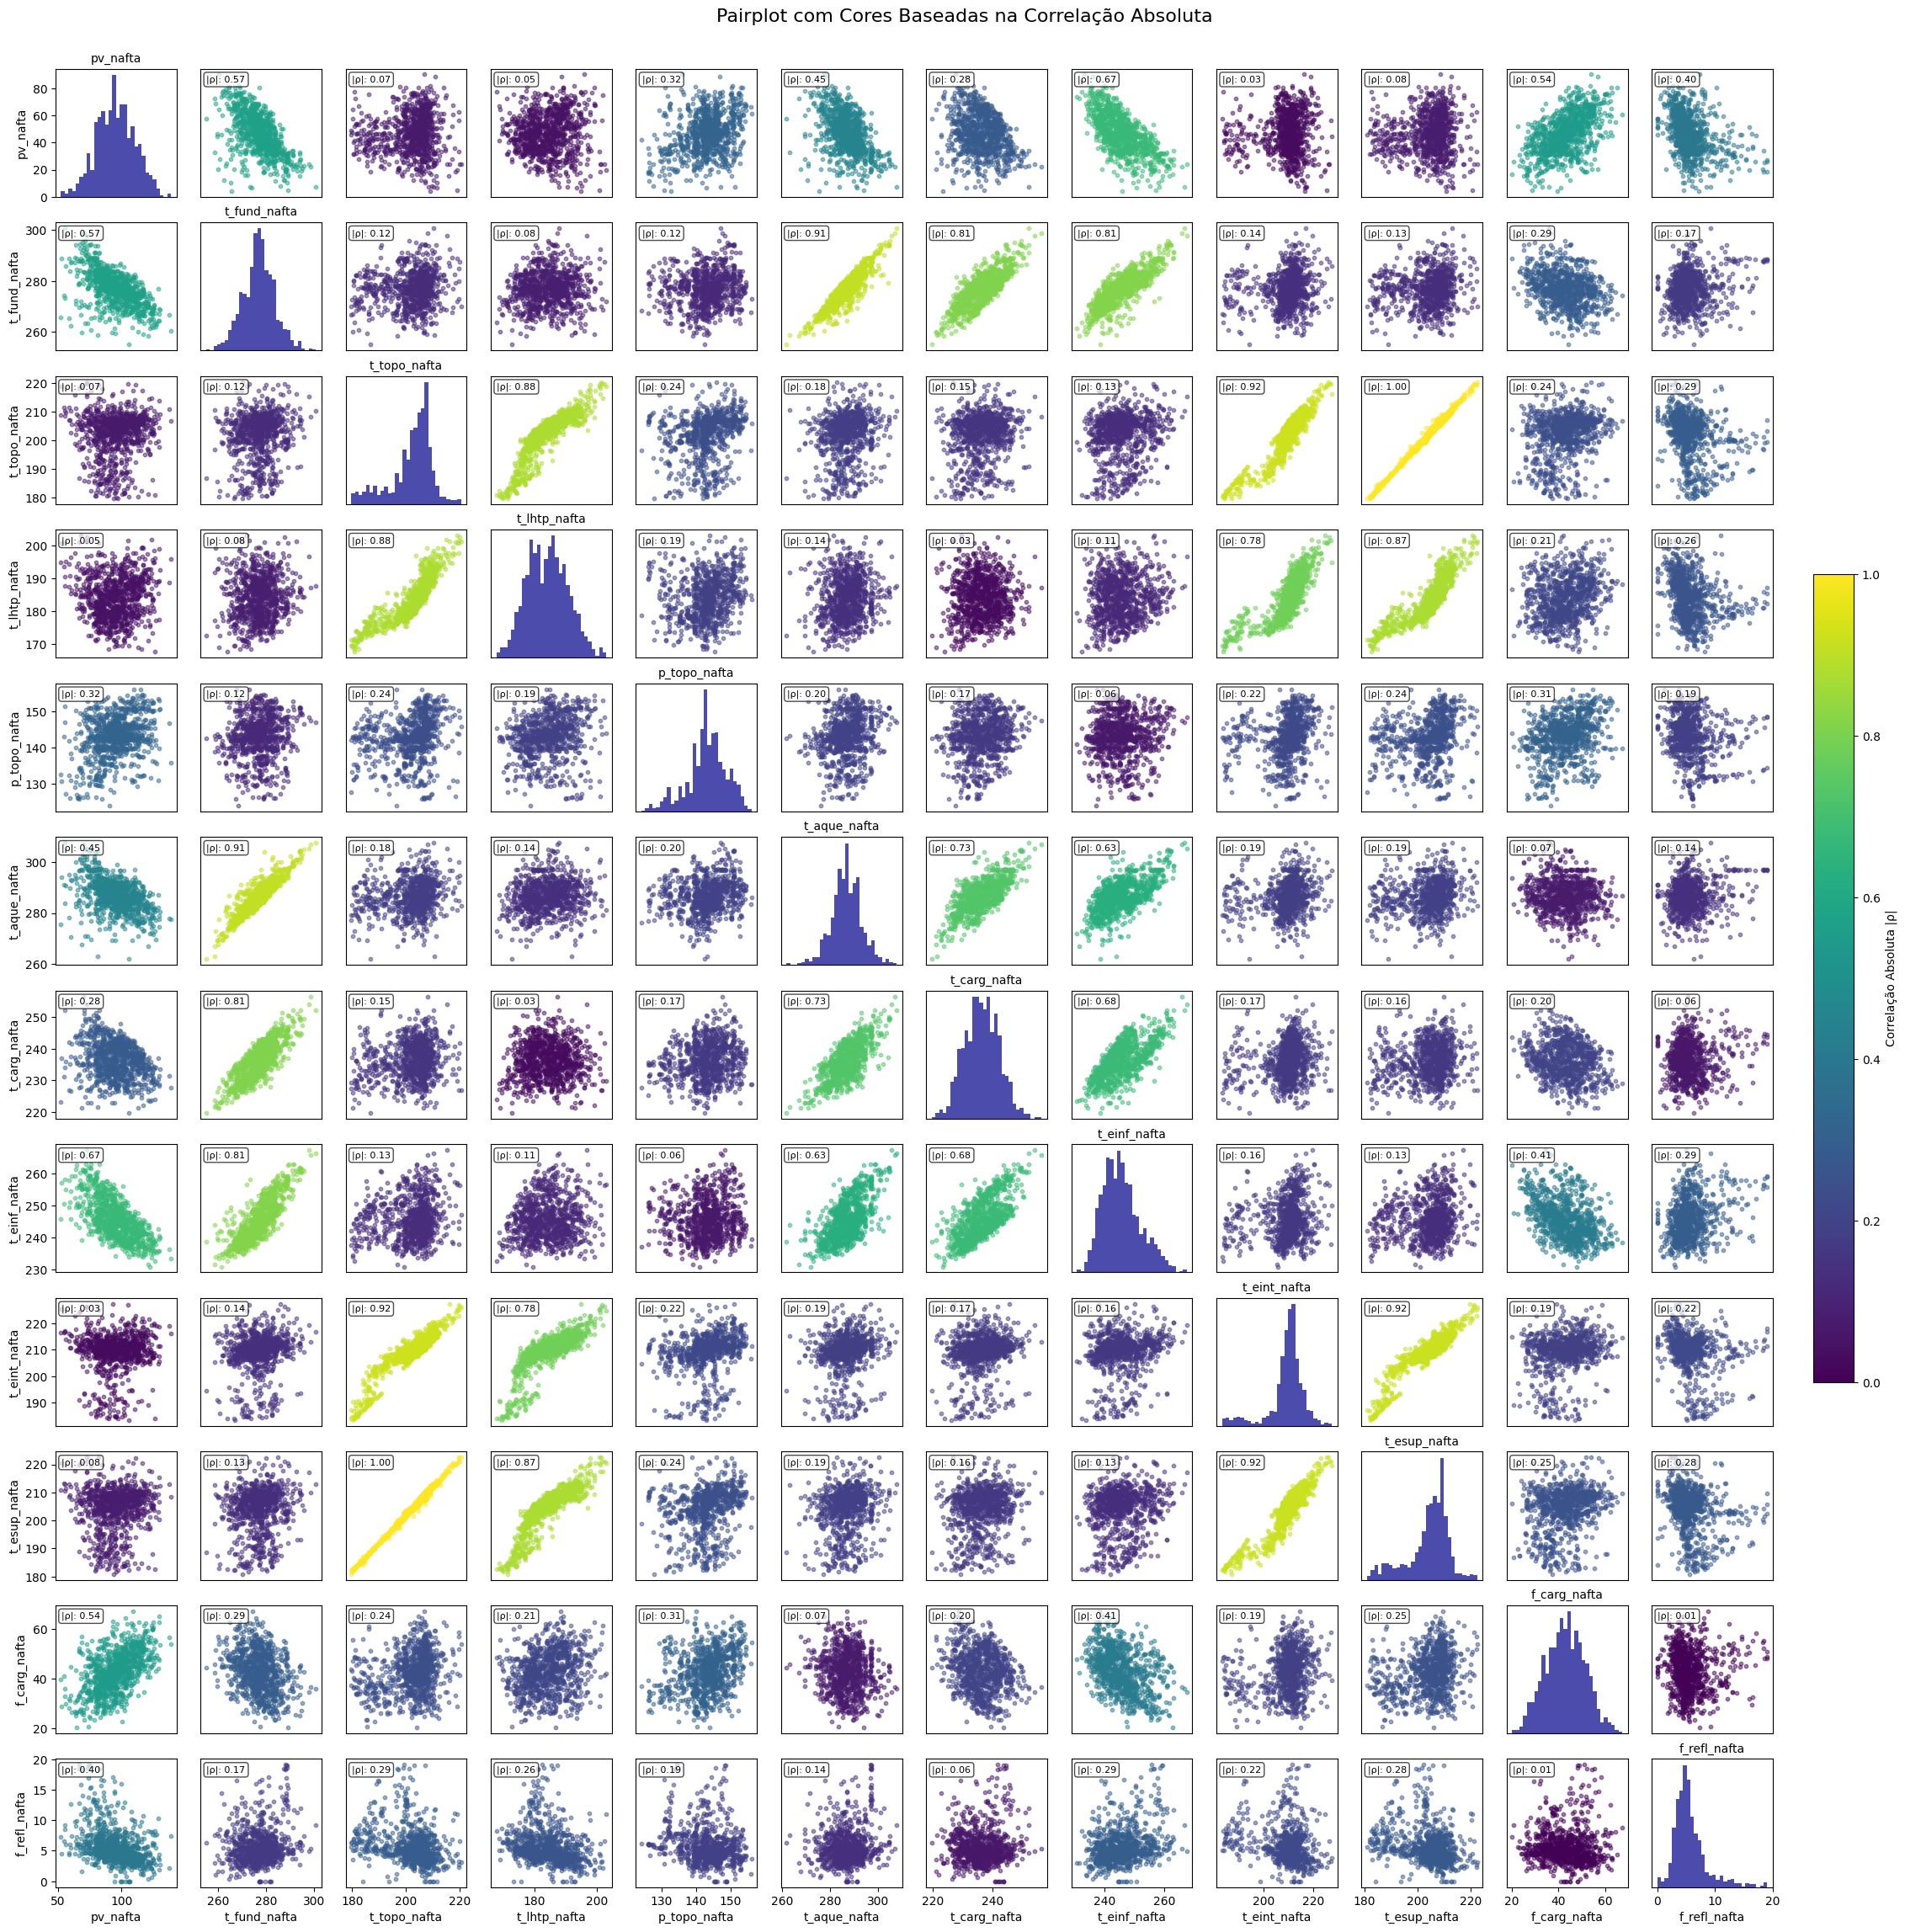

In [7]:
# Matriz de correlação
print("\nPara simplificar a visualização de correlação linear, o mapa de calor será realizado com o valor absoluto da correlação [0,1] ao invés de [-1, 1]\n")
# print(df.corr())
calcula_corr(df)
pairplot_corr_hm(df, figsize=(24, 24), hist_bins=30, s=10, alpha=0.5)

In [8]:
calcula_vif(df,target)


VIF das variáveis (ordem decrescente):

Variable  t_topo_nafta  t_esup_nafta  t_fund_nafta  t_aque_nafta  t_eint_nafta  t_lhtp_nafta  t_einf_nafta  t_carg_nafta  f_carg_nafta  f_refl_nafta  p_topo_nafta
VIF           218.7763      201.5114       16.9370        8.8134        7.3350        4.9637        4.9526        3.4376        1.9126        1.5913        1.2944


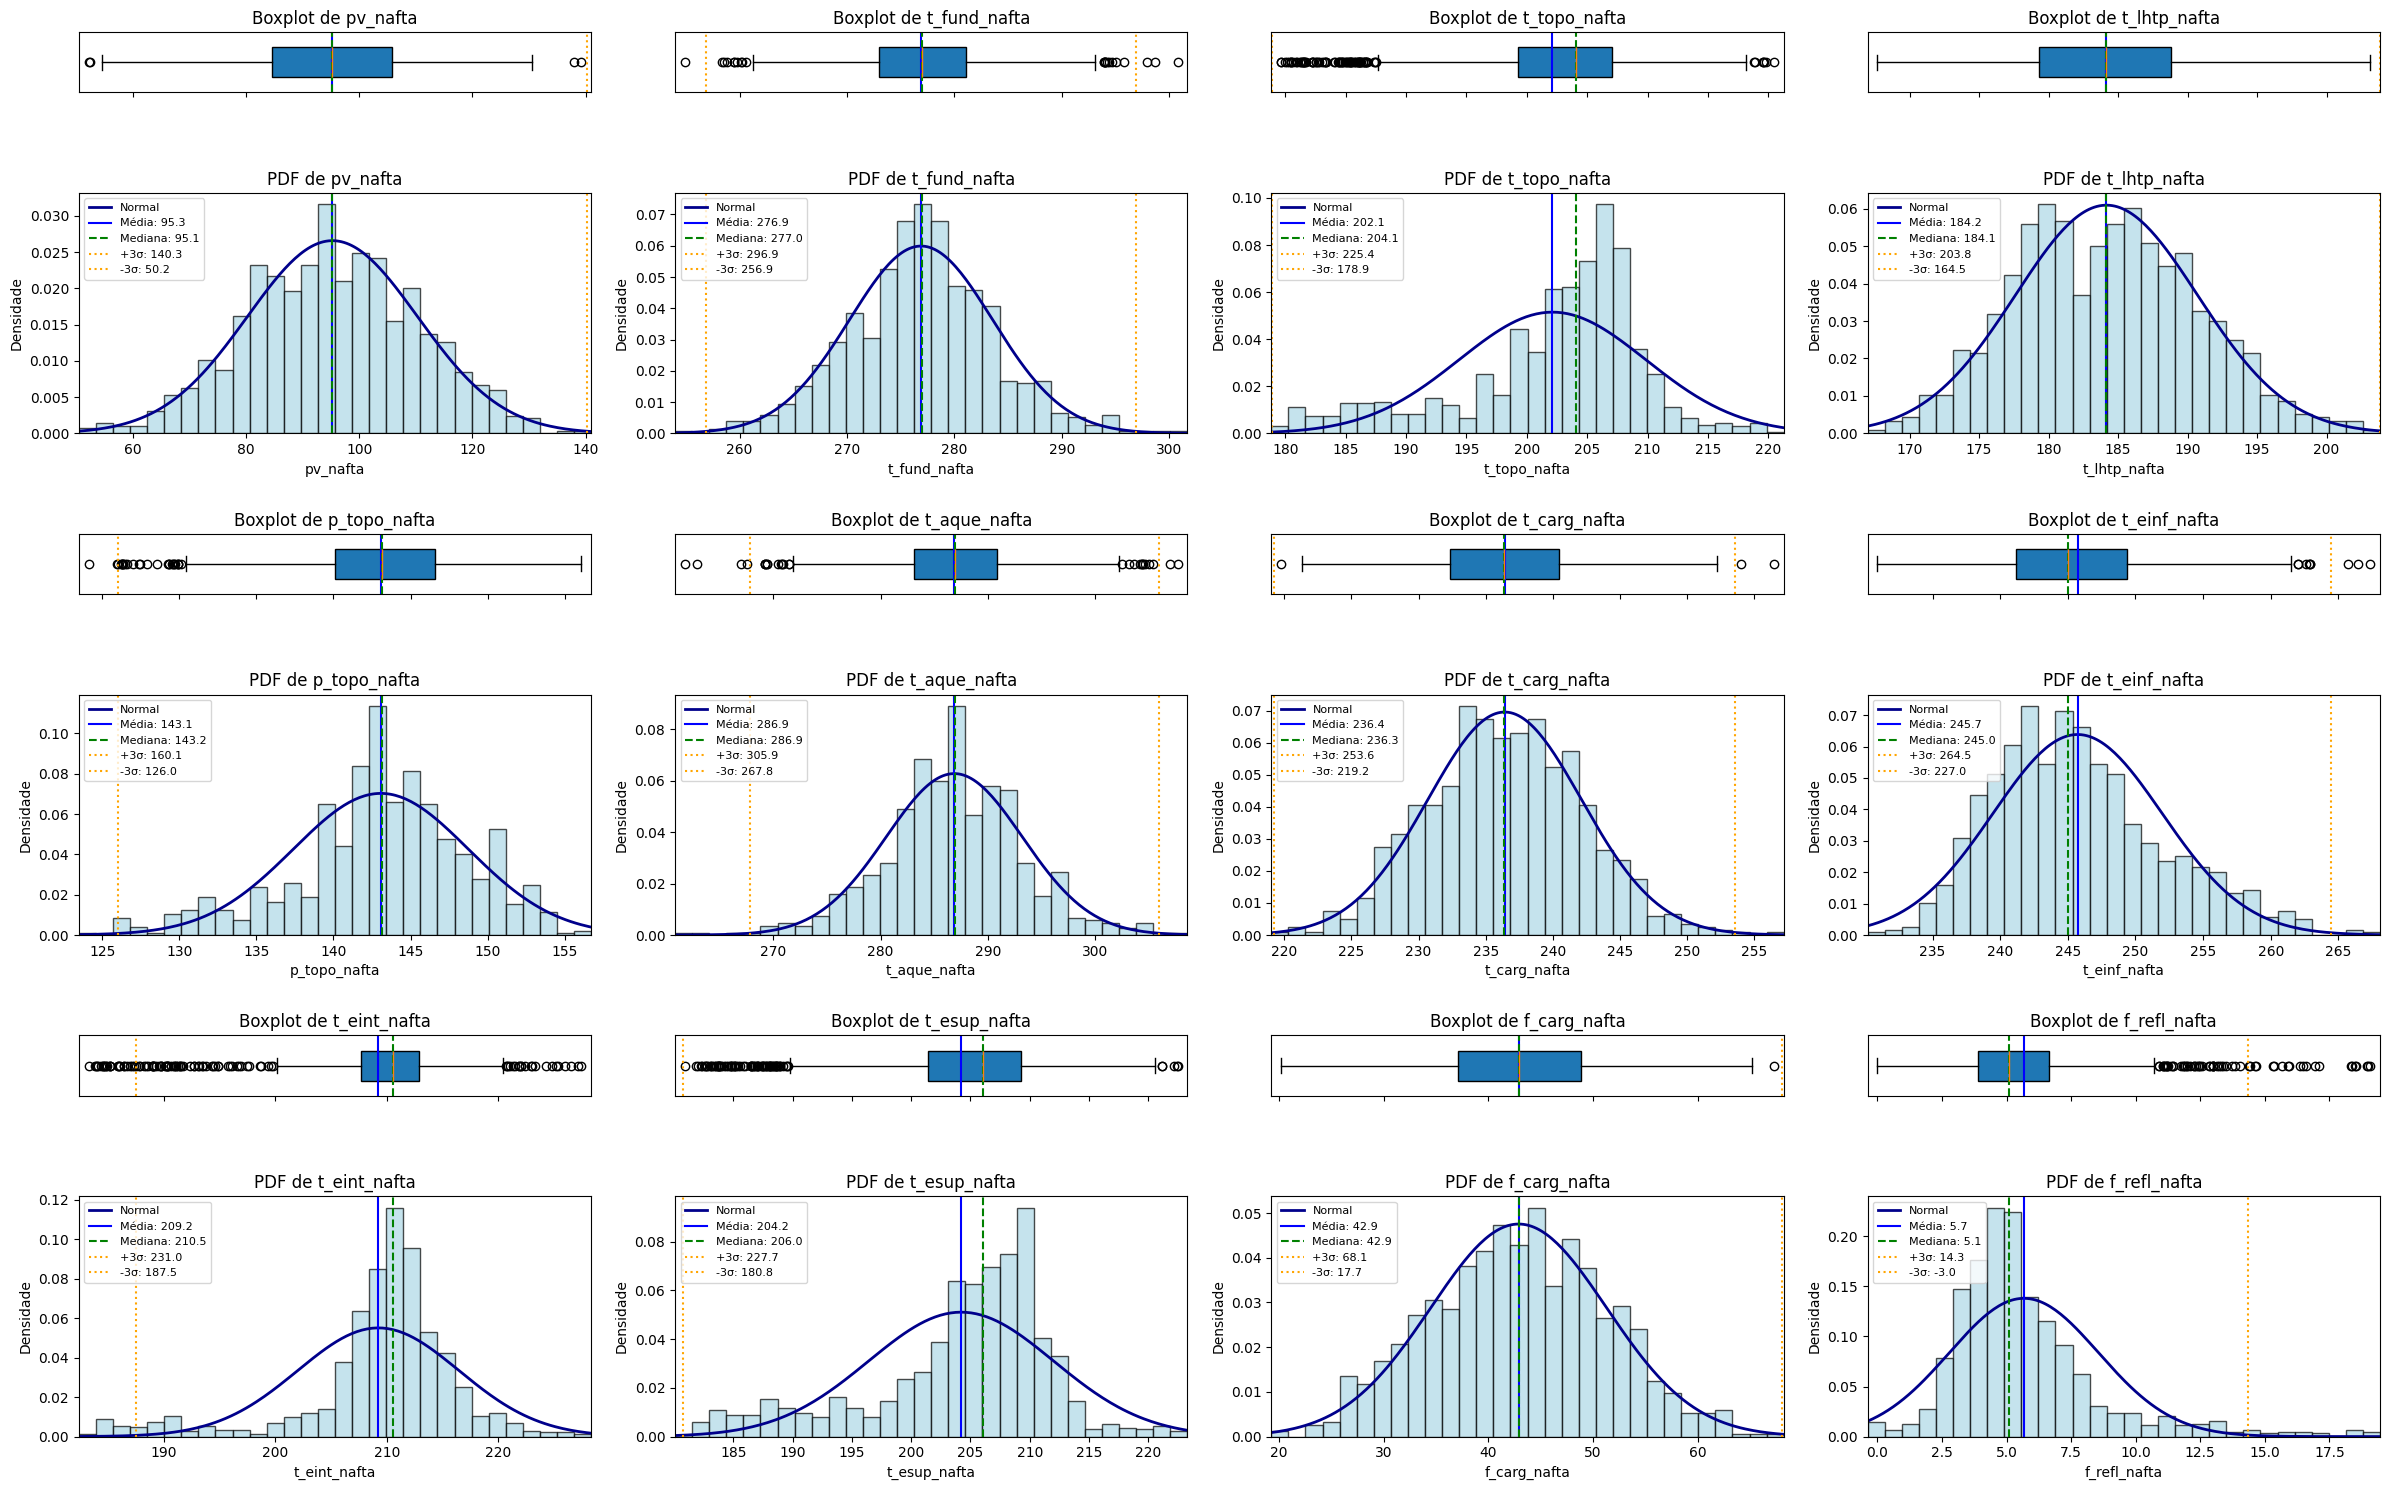

In [9]:
plot_boxplot_pdf(df)

In [10]:
# Definição do problema e inicialização de variáveis
SEED = 42
PROBLEM_TYPE = "regressao"
SPLIT = 0.2
CV_FOLDS = 10

In [11]:
X = df.drop(target, axis=1)
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=SEED, stratify=y if PROBLEM_TYPE=="classificacao" else None
)
print("Treino:", X_train.shape, "| Teste:", X_test.shape)
print("Tipo:", PROBLEM_TYPE)
print("Target:", target)
print("Nº features:", X.shape[1])

Treino: (756, 11) | Teste: (189, 11)
Tipo: regressao
Target: pv_nafta
Nº features: 11


In [12]:
# Lista de métodos de padronização
scalers = [
    # ("minmax", MinMaxScaler())
    ("standard", StandardScaler())
]

# Lista de modelos candidatos e seus hiperparâmetros para otimização
# Imports para modelos externos (se ainda não importados)
candidates = [
    (
        "linear",
        LinearRegression(),
        {}  # Linear Regression não tem hiperparâmetros para otimizar
    ),
    (
        "ridge",
        Ridge(),
        {
            "regressor__alpha": Real(0.01, 100.0, prior="log-uniform")
        }
    ),
    (
        "lasso",
        Lasso(),
        {
            "regressor__alpha": Real(0.01, 100.0, prior="log-uniform")
        }
    ),
    (
        "elasticnet",
        ElasticNet(),
        {
            "regressor__alpha": Real(0.01, 10.0, prior="log-uniform"),
            "regressor__l1_ratio": Real(0.1, 0.9)
        }
    ),
    (
        "randomforest",
        RandomForestRegressor(random_state=SEED),
        {
            "regressor__n_estimators": Integer(100, 500),
            "regressor__max_depth": Categorical([None, 5, 10, 20]),
            "regressor__min_samples_split": Integer(2, 10)
        }
    ),
    (
        "extratrees",
        ExtraTreesRegressor(random_state=SEED),
        {
            "regressor__n_estimators": Integer(100, 500),
            "regressor__max_depth": Categorical([None, 5, 10, 20]),
            "regressor__min_samples_split": Integer(2, 10)
        }
    ),
    (
        "gbr",
        GradientBoostingRegressor(random_state=SEED),
        {
            "regressor__n_estimators": Integer(100, 500),
            "regressor__learning_rate": Real(0.01, 0.1, prior="log-uniform"),
            "regressor__max_depth": Integer(3, 10)
        }
    ),
    (
        "xgboost",
        XGBRegressor(random_state=SEED, verbosity=0),
        {
            "regressor__n_estimators": Integer(100, 500),
            "regressor__learning_rate": Real(0.01, 0.1, prior="log-uniform"),
            "regressor__max_depth": Integer(3, 10),
            "regressor__subsample": Real(0.8, 1.0),
            "regressor__colsample_bytree": Real(0.8, 1.0)
        }
    ),
    (
        "lightgbm",
        LGBMRegressor(random_state=SEED, force_col_wise=True, min_split_gain=0.1, verbose=-1),
        {
            "regressor__n_estimators": Integer(100, 500),
            "regressor__learning_rate": Real(0.01, 0.1, prior="log-uniform"),
            "regressor__max_depth": Categorical([3, 5, 10, -1]),
            "regressor__num_leaves": Integer(31, 100)
        }
    ),
    (
        "catboost",
        CatBoostRegressor(random_state=SEED, verbose=0),
        {
            "regressor__iterations": Integer(100, 500),
            "regressor__learning_rate": Real(0.01, 0.1, prior="log-uniform"),
            "regressor__depth": Integer(3, 10)
        }
    ),
    (
        "svr",
        SVR(),
        {
            "regressor__C": Real(0.1, 100, prior="log-uniform"),
            "regressor__epsilon": Real(0.01, 1, prior="log-uniform"),
            "regressor__kernel": Categorical(["rbf", "linear"])
        }
    )
]


# Modelo baseline (LinearRegression)
baseline_algorithm = candidates[0]

# Agora você pode acessar facilmente:
print(f"Baseline model: {baseline_algorithm[0]} - {baseline_algorithm[1]}")
print(f"Total de candidatos (incluindo baseline): {len(candidates)}")

# Verificar a estrutura
for i, (name, model, params) in enumerate(candidates):
    print(f"candidates[{i}]: {name}")

Baseline model: linear - LinearRegression()
Total de candidatos (incluindo baseline): 11
candidates[0]: linear
candidates[1]: ridge
candidates[2]: lasso
candidates[3]: elasticnet
candidates[4]: randomforest
candidates[5]: extratrees
candidates[6]: gbr
candidates[7]: xgboost
candidates[8]: lightgbm
candidates[9]: catboost
candidates[10]: svr


In [13]:
# Baseline com LinearRegression usando estrutura unificada
scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'rmse': make_scorer(rmse_score, greater_is_better=False),
    'mae': 'neg_mean_absolute_error'
}

# Pegar o baseline (primeiro elemento da lista candidates)
baseline_name, baseline_model, _ = baseline_algorithm

print("="*80)
print(f"BASELINE - {baseline_name.upper()}: {baseline_model}")
print("="*80)

# Loop através de todas as configurações de scaler da lista scalers
for scaler_name, scaler in scalers:
    pipeline = Pipeline([
        ('scaler', scaler),
        ('regressor', baseline_model)
    ])

    # Validação cruzada
    cv_results = cross_validate(
        pipeline, X_train, y_train,
        cv=CV_FOLDS,
        scoring=scoring,
        return_train_score=True
    )

    # Adicionar resultados ao DataFrame unificado
    all_results_df = add_results_to_df(
        all_results_df,
        model_name=baseline_name,  # Usar o nome do candidates[0]
        scaler_name=scaler_name,
        cv_results=cv_results,
        hyperparams='default',
        optimization_method='baseline'
    )

    print_metrics_table(baseline_name, scaler_name, cv_results)

# Filtrar resultados do baseline
baseline_results = all_results_df[
    (all_results_df['model_name'] == baseline_name) & 
    (all_results_df['optimization_method'] == 'baseline')
].copy()

# Melhor configuração
best_baseline = baseline_results.loc[baseline_results['r2_cv_mean'].idxmax()]
print(f"\nMelhor configuração baseline {baseline_name}:")
print(f"- Scaler: {best_baseline['scaler']}")
print(f"- R² CV: {best_baseline['r2_cv_mean']:.4f}")
print(f"- RMSE CV: {best_baseline['rmse_cv_mean']:.4f}")
print(f"- Data do experimento: {best_baseline['experiment_date']}")


BASELINE - LINEAR: LinearRegression()

Modelo: LINEAR com Scaler: standard
+-----------+---------------------------+-----------------------+
| Métrica   | Treino (média ± desvio)   | CV (média ± desvio)   |
+===========+===========================+=======================+
| R²        | 0.7574 (±0.0109)          | 0.7257 (±0.1107)      |
+-----------+---------------------------+-----------------------+
| RMSE      | 7.4160 (±0.1696)          | 7.5607 (±1.5288)      |
+-----------+---------------------------+-----------------------+

Melhor configuração baseline linear:
- Scaler: standard
- R² CV: 0.7257
- RMSE CV: 7.5607
- Data do experimento: 2025-08-30 20:11:23


In [14]:
# Loop através dos outros candidatos (excluindo o baseline)
# O nome do baseline já foi extraído na célula anterior para a variável baseline_name
other_candidates = [candidate for candidate in candidates if candidate[0] != baseline_name]

print("Iniciando avaliação dos modelos candidatos...")


# Loop através de cada modelo candidato
for model_name, model, _ in other_candidates:

    # Cria o pipeline com o scaler e o modelo
    pipeline = Pipeline([
        ('scaler', scaler),
        ('regressor', clone(model))  # Usar clone para garantir que o modelo seja resetado a cada iteração
    ])

    # Validação cruzada
    cv_results = cross_validate(
        pipeline, X_train, y_train,
        cv=CV_FOLDS,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1 # Utiliza todos os processadores para acelerar
    )

    # Adicionar resultados ao DataFrame unificado
    all_results_df = add_results_to_df(
        all_results_df,
        model_name=model_name,
        scaler_name=scaler_name,
        cv_results=cv_results,
        hyperparams='default',
        optimization_method='baseline' # Ainda estamos na fase de baseline para estes modelos
    )

print("="*80)
print("Cálculos concluídos.")



Iniciando avaliação dos modelos candidatos...
Cálculos concluídos.
Cálculos concluídos.


In [16]:
# Loop para EXIBIR os resultados a partir do DataFrame
for model_name, _, _ in other_candidates:
    
    # Filtra o DataFrame para o modelo atual
    model_results_df = all_results_df[
        (all_results_df['model_name'] == model_name) &
        (all_results_df['optimization_method'] == 'baseline')
    ]



# Exibir um resumo dos melhores resultados encontrados até agora
display_results_summary(all_results_df, top_n=10, metric='r2_cv_mean')


TOP 10 MODELOS - Ordenados por R2_CV_MEAN
  model_name   scaler optimization_method  r2_cv_mean  mse_cv_mean  rmse_cv_mean  mae_cv_mean
    catboost standard            baseline      0.7929      44.4165        6.5562       4.4758
    lightgbm standard            baseline      0.7734      48.3515        6.8509       4.7842
  extratrees standard            baseline      0.7650      51.1956        7.0465       4.9016
         gbr standard            baseline      0.7598      51.5242        7.0700       5.0356
randomforest standard            baseline      0.7574      52.4948        7.1385       5.1378
     xgboost standard            baseline      0.7521      52.7649        7.1914       5.1358
       ridge standard            baseline      0.7265      59.4401        7.5670       5.5615
      linear standard            baseline      0.7257      59.5019        7.5607       5.5667
       lasso standard            baseline      0.6764      71.6289        8.3152       6.2482
         svr stan

In [ ]:
# --- Célula de Otimização de Hiperparâmetros com BayesSearchCV ---

# Parâmetros para a Otimização Bayesiana
N_ITER_BAYES = 30  # Número de iterações da busca. Aumentar para uma busca mais exaustiva.
METRIC_TO_OPTIMIZE = 'r2'

# Dicionário para armazenar os resultados detalhados dos folds para o boxplot
boxplot_data = []

print("="*100)
print(f"Iniciando Otimização Bayesiana de Hiperparâmetros (n_iter={N_ITER_BAYES})")
print(f"Métrica de otimização: {METRIC_TO_OPTIMIZE}")
print("="*100)

# Loop através dos candidatos e scalers
for model_name, model, params in candidates:
    # Pula modelos que não têm hiperparâmetros para otimizar
    if not params:
        print(f"\n--- Modelo '{model_name.upper()}' sem hiperparâmetros para otimizar. Pulando. ---")
        continue

    start_time = time.time()
    print(f"\nOtimizando: {model_name.upper()} com Scaler: {scaler_name}...")

    # 1. Cria o pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('regressor', clone(model))
    ])

    # 2. Configura o BayesSearchCV
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=params,
        n_iter=N_ITER_BAYES,
        cv=KFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED),
        scoring=METRIC_TO_OPTIMIZE,
        n_jobs=-1,
        random_state=SEED,
        return_train_score=True,
        refit=True
    )

    # 3. Executa a busca
    bayes_search.fit(X_train, y_train)
    
    end_time = time.time()
    print(f"Otimização concluída em {end_time - start_time:.2f} segundos.")
    print(f"Melhor R² (CV): {bayes_search.best_score_:.4f}")

    # 4. Adiciona os resultados ao DataFrame principal
    # O BayesSearchCV não retorna todas as métricas no cv_results, então criamos um dict compatível
    best_index = bayes_search.best_index_
    cv_results_for_df = {
        'train_r2': bayes_search.cv_results_['mean_train_score'][best_index],
        'test_r2': bayes_search.cv_results_['mean_test_score'][best_index],
        # Adicionando placeholders para outras métricas, pois não foram calculadas na busca
        'train_mse': np.array([np.nan] * CV_FOLDS), 'test_mse': np.array([np.nan] * CV_FOLDS),
        'train_rmse': np.array([np.nan] * CV_FOLDS), 'test_rmse': np.array([np.nan] * CV_FOLDS),
        'train_mae': np.array([np.nan] * CV_FOLDS), 'test_mae': np.array([np.nan] * CV_FOLDS),
        'fit_time': bayes_search.cv_results_['mean_fit_time'],
        'score_time': bayes_search.cv_results_['mean_score_time']
    }

    all_results_df = add_results_to_df(
        all_results_df,
        model_name=model_name,
        scaler_name=scaler_name,
        cv_results=cv_results_for_df,
        hyperparams=bayes_search.best_params_,
        optimization_method='bayes_search'
    )
    
    # 5. Guarda os dados dos folds (treino e teste) para o boxplot
    for fold_idx in range(CV_FOLDS):
        boxplot_data.append({
            'model_name': model_name,
            'scaler': scaler_name,
            'type': 'Train',
            'r2_score': bayes_search.cv_results_[f'split{fold_idx}_train_score'][best_index]
        })
        boxplot_data.append({
            'model_name': model_name,
            'scaler': scaler_name,
            'type': 'Test (CV)',
            'r2_score': bayes_search.cv_results_[f'split{fold_idx}_test_score'][best_index]
        })

print("\n" + "="*100)
print("TODAS AS OTIMIZAÇÕES FORAM CONCLUÍDAS.")
print("="*100)



Iniciando Otimização Bayesiana de Hiperparâmetros (n_iter=30)
Métrica de otimização: r2

--- Modelo 'LINEAR' sem hiperparâmetros para otimizar. Pulando. ---

Otimizando: RIDGE com Scaler: standard...
Otimização concluída em 10.53 segundos.
Melhor R² (CV): 0.7450

Otimizando: LASSO com Scaler: standard...
Otimização concluída em 10.53 segundos.
Melhor R² (CV): 0.7450

Otimizando: LASSO com Scaler: standard...
Otimização concluída em 9.24 segundos.
Melhor R² (CV): 0.7444

Otimizando: ELASTICNET com Scaler: standard...
Otimização concluída em 9.24 segundos.
Melhor R² (CV): 0.7444

Otimizando: ELASTICNET com Scaler: standard...
Otimização concluída em 12.19 segundos.
Melhor R² (CV): 0.7435

Otimizando: RANDOMFOREST com Scaler: standard...
Otimização concluída em 12.19 segundos.
Melhor R² (CV): 0.7435

Otimizando: RANDOMFOREST com Scaler: standard...
Otimização concluída em 110.73 segundos.
Melhor R² (CV): 0.7738

Otimizando: EXTRATREES com Scaler: standard...
Otimização concluída em 110.73

KeyError: '[0] not in index'

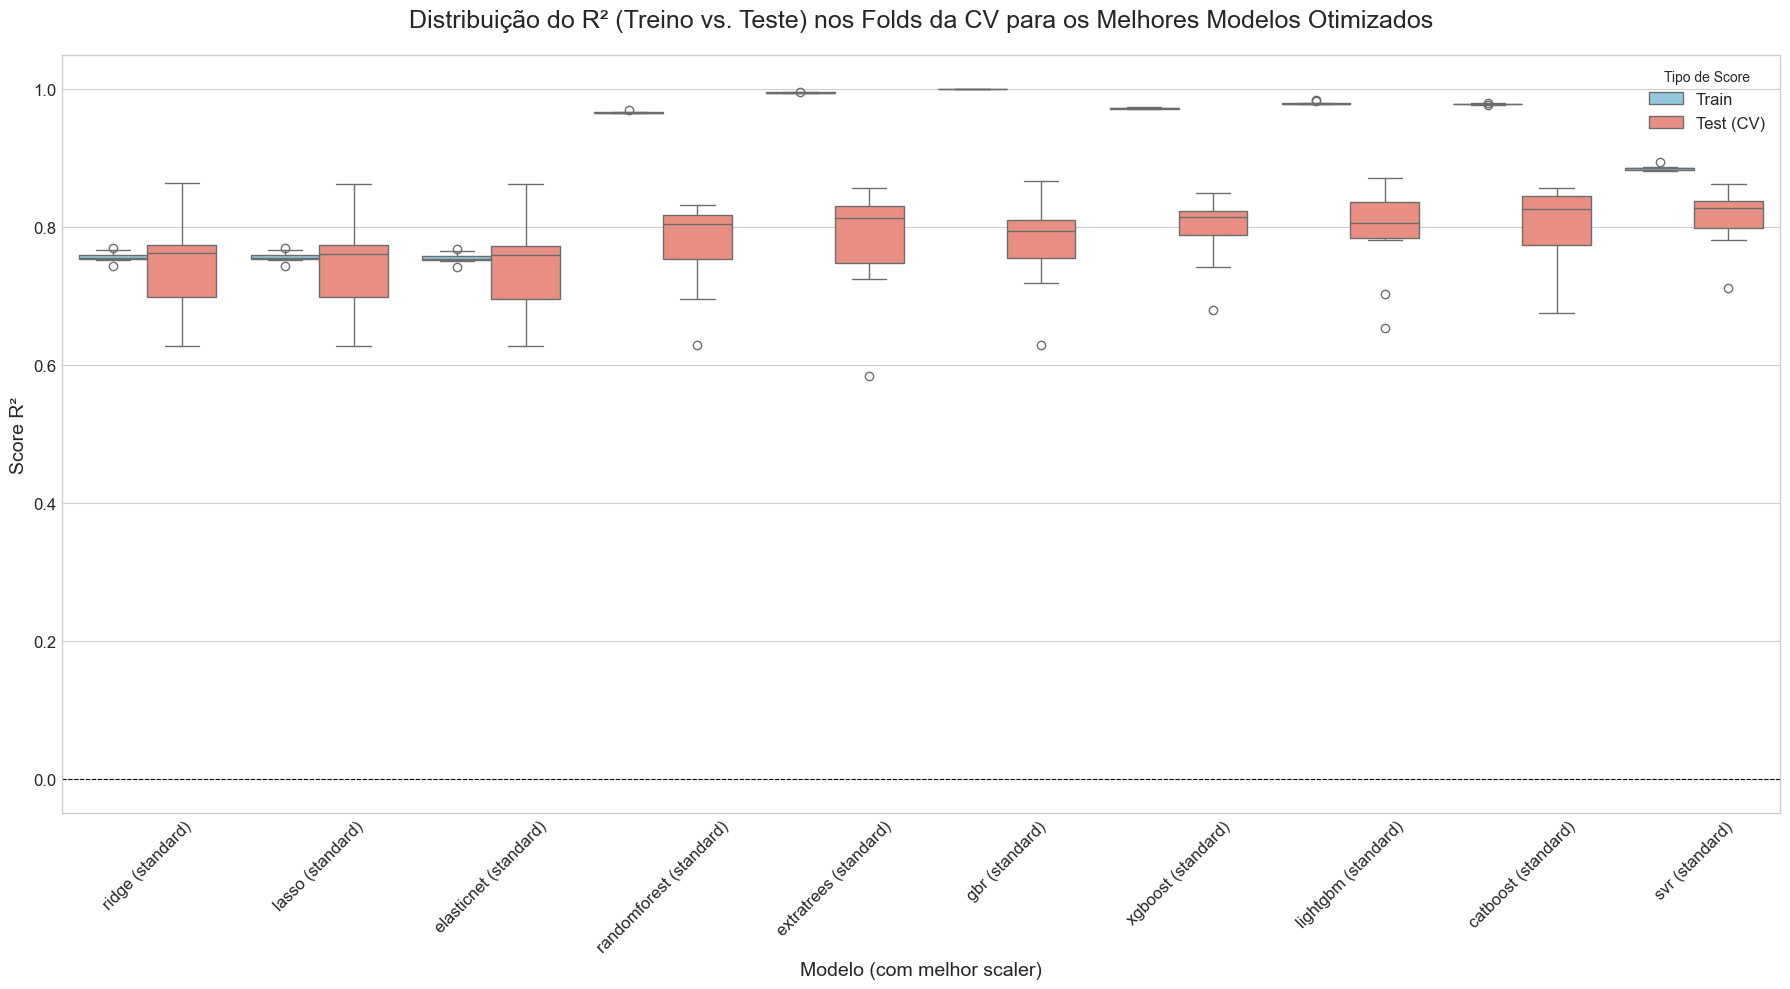


Resumo Geral dos Melhores Modelos (Incluindo Baseline e Otimizados)

TOP 15 MODELOS - Ordenados por R2_CV_MEAN
  model_name   scaler optimization_method  r2_cv_mean  mse_cv_mean  rmse_cv_mean  mae_cv_mean
         svr standard        bayes_search      0.8139          NaN           NaN          NaN
    catboost standard        bayes_search      0.8022          NaN           NaN          NaN
     xgboost standard        bayes_search      0.7965          NaN           NaN          NaN
    catboost standard            baseline      0.7929      44.4165        6.5562       4.4758
    lightgbm standard        bayes_search      0.7925          NaN           NaN          NaN
  extratrees standard        bayes_search      0.7813          NaN           NaN          NaN
         gbr standard        bayes_search      0.7772          NaN           NaN          NaN
randomforest standard        bayes_search      0.7738          NaN           NaN          NaN
    lightgbm standard            baseline 

In [19]:
# --- Célula de Visualização dos Resultados da Otimização ---

# Criar um DataFrame a partir dos dados do boxplot
boxplot_df = pd.DataFrame(boxplot_data)

bayes_results_df = all_results_df[all_results_df['optimization_method'] == 'bayes_search'].copy()

# Filtrar apenas os melhores resultados de cada modelo (melhor scaler)
best_optimized_models = bayes_results_df.loc[
    bayes_results_df.groupby('model_name')['r2_cv_mean'].idxmax()
]

# Criar uma lista com os nomes dos melhores modelos e seus scalers para o filtro
best_model_scaler_pairs = list(zip(best_optimized_models['model_name'], best_optimized_models['scaler']))

# Filtrar o boxplot_df para conter apenas os melhores
best_boxplot_df = boxplot_df[
    boxplot_df.apply(lambda row: (row['model_name'], row['scaler']) in best_model_scaler_pairs, axis=1)
].copy()

# Adicionar uma coluna de identificação para o plot
best_boxplot_df['model_id'] = best_boxplot_df['model_name'] + ' (' + best_boxplot_df['scaler'] + ')'


# Plotar o boxplot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))

sns.boxplot(
    data=best_boxplot_df,
    x='model_id',
    y='r2_score',
    hue='type',
    ax=ax,
    palette={'Train': 'skyblue', 'Test (CV)': 'salmon'}
)

ax.set_title(f'Distribuição do R² (Treino vs. Teste) nos Folds da CV para os Melhores Modelos Otimizados', fontsize=18, pad=20)
ax.set_xlabel('Modelo (com melhor scaler)', fontsize=14)
ax.set_ylabel('Score R²', fontsize=14)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title='Tipo de Score', fontsize=12)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8) # Linha de referência R²=0
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

# Exibir o resumo dos melhores modelos, incluindo os otimizados
print("\n" + "="*100)
print("Resumo Geral dos Melhores Modelos (Incluindo Baseline e Otimizados)")
print("="*100)
display_results_summary(all_results_df, top_n=15, metric='r2_cv_mean')

In [20]:
print("Melhores hiperparâmetros encontrados:")
print(bayes_search.best_params_)

Melhores hiperparâmetros encontrados:
OrderedDict([('regressor__C', 21.27998667701231), ('regressor__epsilon', 0.01), ('regressor__kernel', 'rbf')])


In [21]:
# --- Avaliação do Melhor Modelo no Conjunto de Teste (Dados Não Vistos) ---

# 1. O `best_estimator_` do BayesSearchCV é o pipeline já treinado com os melhores parâmetros
#    encontrados na última busca. Vamos usá-lo para prever nos dados de teste.
#    Nota: Isso usa o melhor estimador da ÚLTIMA busca no loop (neste caso, SVR).
#    Se o melhor modelo geral for outro, o processo seria um pouco diferente.
best_model_final = bayes_search.best_estimator_

# 2. Fazer previsões no conjunto de teste
y_pred_test = best_model_final.predict(X_test)

# 3. Calcular as métricas de avaliação
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# 4. Exibir os resultados
print("="*80)
print(f"Resultados do Melhor Modelo no Conjunto de Teste (X_test)")
# Extrai o nome do modelo do pipeline para exibição
model_name_in_pipeline = best_model_final.named_steps['regressor'].__class__.__name__
print(f"Modelo: {model_name_in_pipeline}")
print("="*80)

metrics_data = [
    ["R² (R-squared)", f"{r2_test:.4f}"],
    ["MSE (Mean Squared Error)", f"{mse_test:.4f}"],
    ["RMSE (Root Mean Squared Error)", f"{rmse_test:.4f}"],
    ["MAE (Mean Absolute Error)", f"{mae_test:.4f}"]
]
headers = ["Métrica", "Valor no Conjunto de Teste"]

print(tabulate(metrics_data, headers=headers, tablefmt="grid"))
print("="*80)

Resultados do Melhor Modelo no Conjunto de Teste (X_test)
Modelo: SVR
+--------------------------------+------------------------------+
| Métrica                        |   Valor no Conjunto de Teste |
+================================+==============================+
| R² (R-squared)                 |                       0.8071 |
+--------------------------------+------------------------------+
| MSE (Mean Squared Error)       |                      41.9951 |
+--------------------------------+------------------------------+
| RMSE (Root Mean Squared Error) |                       6.4804 |
+--------------------------------+------------------------------+
| MAE (Mean Absolute Error)      |                       4.2004 |
+--------------------------------+------------------------------+


In [23]:
import ast

# --- Retreinamento do Melhor Modelo com Todos os Dados ---

print("="*80)
print("Retreinando o melhor modelo com o dataset completo (X, y)")
print("="*80)

# 1. Identificar o melhor modelo geral a partir dos resultados
best_model_info = all_results_df.loc[all_results_df['r2_cv_mean'].idxmax()]

best_model_name = best_model_info['model_name']
best_scaler_name = best_model_info['scaler']
best_params_str = best_model_info['hyperparams']

# Converter a string de hiperparâmetros de volta para um dicionário
# Usar ast.literal_eval é mais seguro do que eval()
try:
    best_params = ast.literal_eval(best_params_str)
except (ValueError, SyntaxError):
    best_params = {} # Caso os hiperparâmetros sejam 'default' ou algo não-dicionário

# 2. Encontrar os objetos originais do modelo e do scaler
model_obj = None
for name, model, _ in candidates:
    if name == best_model_name:
        model_obj = clone(model)
        break

scaler_obj = None
for name, scaler in scalers:
    if name == best_scaler_name:
        scaler_obj = scaler
        break

if model_obj is None or scaler_obj is None:
    print("Erro: Não foi possível encontrar o modelo ou scaler correspondente.")
else:
    # 3. Criar o pipeline final
    final_pipeline = Pipeline([
        ('scaler', scaler_obj),
        ('regressor', model_obj)
    ])

    # 4. Definir os melhores hiperparâmetros no pipeline
    # Adiciona o prefixo 'regressor__' se não estiver presente
    final_params = {}
    for key, value in best_params.items():
        if not key.startswith('regressor__'):
            final_params[f'regressor__{key}'] = value
        else:
            final_params[key] = value
            
    final_pipeline.set_params(**final_params)

    # 5. Retreinar o pipeline com todos os dados (X e y)
    print(f"Modelo selecionado: {best_model_name.upper()}")
    print(f"Scaler: {best_scaler_name}")
    print(f"Hiperparâmetros: {best_params}")
    
    start_fit_time = time.time()
    final_pipeline.fit(X, y)
    end_fit_time = time.time()
    
    print(f"\nTreinamento com dados completos concluído em {end_fit_time - start_fit_time:.2f} segundos.")

    # 6. Fazer previsões nos próprios dados de treinamento para avaliar o ajuste
    y_pred_full = final_pipeline.predict(X)

    # 7. Calcular e exibir as métricas de desempenho no conjunto de dados completo
    r2_full = r2_score(y, y_pred_full)
    mse_full = mean_squared_error(y, y_pred_full)
    rmse_full = np.sqrt(mse_full)
    mae_full = mean_absolute_error(y, y_pred_full)

    print("\n" + "="*80)
    print("Métricas do Modelo Final (avaliadas no dataset completo)")
    
    full_metrics_data = [
        ["R² (R-squared)", f"{r2_full:.4f}"],
        ["MSE (Mean Squared Error)", f"{mse_full:.4f}"],
        ["RMSE (Root Mean Squared Error)", f"{rmse_full:.4f}"],
        ["MAE (Mean Absolute Error)", f"{mae_full:.4f}"]
    ]
    headers_full = ["Métrica", "Valor no Dataset Completo"]

    print(tabulate(full_metrics_data, headers=headers_full, tablefmt="grid"))
    print("="*80)

Retreinando o melhor modelo com o dataset completo (X, y)
Modelo selecionado: SVR
Scaler: standard
Hiperparâmetros: {}

Treinamento com dados completos concluído em 0.02 segundos.

Métricas do Modelo Final (avaliadas no dataset completo)
+--------------------------------+-----------------------------+
| Métrica                        |   Valor no Dataset Completo |
+================================+=============================+
| R² (R-squared)                 |                      0.7211 |
+--------------------------------+-----------------------------+
| MSE (Mean Squared Error)       |                     62.8068 |
+--------------------------------+-----------------------------+
| RMSE (Root Mean Squared Error) |                      7.9251 |
+--------------------------------+-----------------------------+
| MAE (Mean Absolute Error)      |                      5.4043 |
+--------------------------------+-----------------------------+


In [24]:
# --- Gráficos de Análise do Modelo Final ---

# 1. Calcular o erro
prediction_error = y - y_pred_full

# 2. Criar os subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=(
        "Tendência do Erro de Predição (Real - Previsto)",
        "Comparativo: Valores Reais vs. Valores Previstos"
    )
)

# --- Gráfico 1: Tendência do Erro ---
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=prediction_error,
        mode='lines',
        name='Erro',
        line=dict(color='indianred')
    ),
    row=1, col=1
)
# Adiciona uma linha em y=0 para referência de erro nulo
fig.add_hline(y=0, line_dash="dash", line_color="black", row=1, col=1)

# --- Gráfico 2: Real vs. Previsto ---
# Adiciona a linha dos valores reais
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=y,
        mode='lines',
        name='Valor Real',
        line=dict(color='royalblue')
    ),
    row=2, col=1
)
# Adiciona a linha dos valores previstos
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=y_pred_full,
        mode='lines',
        name='Valor Previsto',
        line=dict(color='darkorange', dash='dot')
    ),
    row=2, col=1
)

# 3. Atualizar o layout geral
fig.update_layout(
    height=700,
    title_text="Análise Gráfica do Desempenho do Modelo Final no Dataset Completo",
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Atualizar os títulos dos eixos
fig.update_yaxes(title_text="Erro (Real - Previsto)", row=1, col=1)
fig.update_yaxes(title_text="Valor da Variável Target", row=2, col=1)
fig.update_xaxes(title_text="Índice da Amostra", row=2, col=1)


fig.show()